In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import ot
import scipy.linalg as spl
from ipywidgets import interact, interactive, fixed, interact_manual

# Dimension 1

In [2]:
def densite_theorique(mu,sigma,alpha,x):
    # compute the 1D GMM density with parameters (mu,sigma) and weights alpha  at x 
    K=mu.shape[0]
    y=0
    #y=np.zeros(len(x))
    for j in range(K):
        y+=alpha[j]*sps.norm.pdf(x,loc=mu[j,:],scale=sigma[j,:,:])
    return y.reshape(x.shape)

In [3]:
def densite_theorique_st(mu,sigma,p,x,df=2):
    '''compute the 1D Mixture Student density with parameters (mu,sigma) and weights p  at x'''
    
    K=mu.shape[0]
    y=0
    for j in range(K):
        y+=p[j]*sps.t.pdf(x,loc=mu[j,:],scale=sigma[j,:,:], df=df)
    return y.reshape(x.shape)

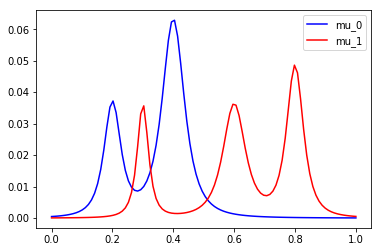

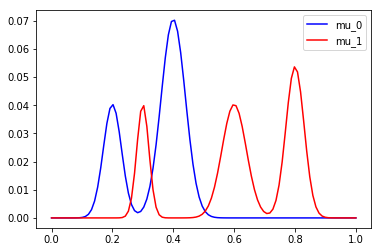

In [4]:
# first Mixture Moments
d=1  # space dimension
pi0 = np.array([.3,.7])    
mu0 = np.array([[.2,.4]]).T
S0  = np.array([[[.03]],[[.04]]])
K0  = pi0.shape[0]

# second Mixture Moments
pi1 = np.array([.4,.4,.2])    
mu1 = np.array([[.6,.8,.3]]).T   
S1 = np.array([[[.04]],[[.03]],[[.02]]])
K1 = pi1.shape[0]

n    = 100
x    = np.linspace(0,1,num=n)

# T densities
st0 = densite_theorique_st(mu0,S0,pi0,x)
st0 = st0/st0.sum()
st1 = densite_theorique_st(mu1,S1,pi1,x)
st1 = st1/st1.sum()

#GMM Densities
gmm0 = densite_theorique(mu0,S0,pi0,x)
gmm0 = gmm0/gmm0.sum()
gmm1 = densite_theorique(mu1,S1,pi1,x)
gmm1 = gmm1/gmm1.sum()

# display densities
plt.plot(x,st0,'b',label='mu_0')
plt.plot(x,st1,'r',label='mu_1')
plt.legend()
plt.show()

plt.plot(x,gmm0,'b',label='mu_0')
plt.plot(x,gmm1,'r',label='mu_1')
plt.legend();

In [5]:
def GaussianW2(m0,m1,Sigma0,Sigma1):
    '''compute the quadratic Wasserstein distance between two Gaussians 
    with means m0 and m1 and covariances Sigma0 and Sigma1
    
    Note: This also works between any two elliptic distributions !'''
    Sigma00  = spl.sqrtm(Sigma0)
    Sigma010 = spl.sqrtm(Sigma00@Sigma1@Sigma00)
    d        = np.linalg.norm(m0-m1)**2+np.trace(Sigma0+Sigma1-2*Sigma010)
    return d

In [6]:
def GW2(pi0,pi1,mu0,mu1,S0,S1):
    '''return the GW2 discrete map and the GW2 distance between two GMM'''
    
    K0 = mu0.shape[0]
    K1 = mu1.shape[0]
    d  = mu0.shape[1]
    S0 = S0.reshape(K0,d,d)
    S1 = S1.reshape(K1,d,d)
    C  = np.zeros((K0,K1))
    
    # First we compute the distance matrix between all Gaussians pairwise
    for k in range(K0):
        for l in range(K1):
            C[k,l]  = GaussianW2(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:])
            
            
    # Then we compute the OT distance or OT map thanks to the OT library (Kantorovich/EMD)
    P     = ot.emd(pi0,pi1,C)         # discrete transport plan
    distGW2   = np.sum(P*C)
    return P,distGW2

In [7]:
P,dist = GW2(pi0,pi1,mu0,mu1,S0,S1)
print(dist)
#P should have less than K0 + K1 - 1 components
print("Number of non zero components: {}, K0+K1-1: {}".format((P>0).sum(), K0+K1-1))
P

0.09456102487748974
Number of non zero components: 4, K0+K1-1: 4


array([[0.1, 0. , 0.2],
       [0.3, 0.4, 0. ]])

In [8]:
def barygmmot(t):
    # Barycenters for GW2 with GMM
    pit = P.reshape(K0*K1,1)
    mut = ((1-t)*mu0+t*mu1.T).reshape(K0*K1,1)
    St = (((1-t) + t*np.sqrt(S1.T/S0))**2*S0).reshape(K0*K1,1,1)
    gmmt = densite_theorique(mut,St,pit,x)
    gmmt = gmmt/gmmt.sum()
    plt.plot(x,gmmt)
    plt.plot(x,gmm0,'r')
    plt.plot(x,gmm1,'k')
    plt.show()
    
def barystot(t):
    # Barycenters for GW2 with T dist
    pit = P.reshape(K0*K1,1)
    mut = ((1-t)*mu0+t*mu1.T).reshape(K0*K1,1)
    St = (((1-t) + t*np.sqrt(S1.T/S0))**2*S0).reshape(K0*K1,1,1)
    st_t = densite_theorique_st(mut,St,pit,x)
    st_t = st_t/st_t.sum()
    plt.plot(x,st_t)
    plt.plot(x,st0,'r')
    plt.plot(x,st1,'k')
    plt.show()

In [9]:
interact(barygmmot,t=(0.0,1.0,0.05));

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.05), Output()), _dom_classes=('w…

In [10]:
interact(barystot,t=(0.0,1.0,0.05));

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.05), Output()), _dom_classes=('w…

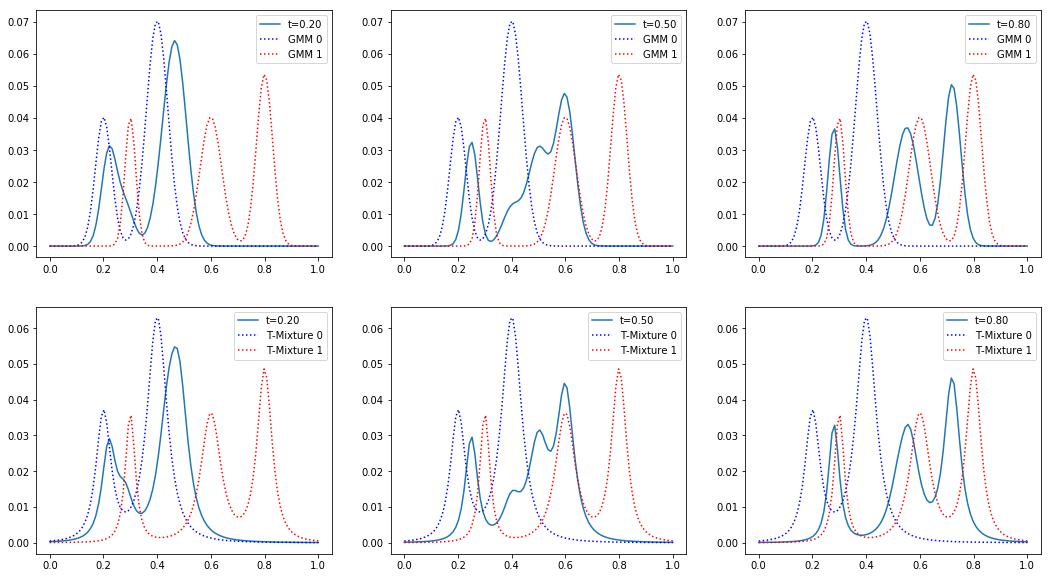

In [15]:
fig  = plt.figure(6, figsize=(18, 10))


pit = P.reshape(K0*K1,1)
for i,t in enumerate([0.2,0.5,.8]):
    mut = ((1-t)*mu0+t*mu1.T).reshape(K0*K1,1)
    St = (((1-t) + t*np.sqrt(S1.T/S0))**2*S0).reshape(K0*K1,1,1)
    gmmt = densite_theorique(mut,St,pit,x)
    gmmt = gmmt/gmmt.sum()
    
    axis = fig.add_subplot(2, 3, i+1)
    axis.plot(x,gmmt,label='t=%.2f' %t)  
    axis.plot(x,gmm0,'b:',label='GMM 0')
    axis.plot(x,gmm1,'r:',label='GMM 1')
    plt.legend();
    
    
for i,t in enumerate([0.2,0.5,.8]):
    mut = ((1-t)*mu0+t*mu1.T).reshape(K0*K1,1)
    St = (((1-t) + t*np.sqrt(S1.T/S0))**2*S0).reshape(K0*K1,1,1)
    st_t = densite_theorique_st(mut,St,pit,x)
    st_t = st_t/st_t.sum()
    
    axis = fig.add_subplot(2, 3, 4+i)
    axis.plot(x,st_t,label='t=%.2f' %t)  
    axis.plot(x,st0,'b:',label='T-Mixture 0')
    axis.plot(x,st1,'r:',label='T-Mixture 1')
    plt.legend();

# Dimension 2 

In [ ]:
import numpy as np
from math import gamma

def multivariate_t_distribution(x, mu, Sigma, df):
    '''
    Multivariate t-student density. Returns the density
    of the function at points specified by x.

    input:
        x = parameter (n-d numpy array; will be forced to 2d)
        mu = mean (d dimensional numpy array)
        Sigma = scale matrix (dxd numpy array)
        df = degrees of freedom

    Edited from: http://stackoverflow.com/a/29804411/3521179
    '''

    x = np.atleast_2d(x) # requires x as 2d
    nD = Sigma.shape[0] # dimensionality

    numerator = gamma(1.0 * (nD + df) / 2.0)

    denominator = (
            gamma(1.0 * df / 2.0) * 
            np.power(df * np.pi, 1.0 * nD / 2.0) *  
            np.power(np.linalg.det(Sigma), 1.0 / 2.0) * 
            np.power(
                1.0 + (1.0 / df) *
                np.diagonal(
                    np.dot( np.dot(x - mu, np.linalg.inv(Sigma)), (x - mu).T)
                ), 
                1.0 * (nD + df) / 2.0
                )
            )

    return 1.0 * numerator / denominator 

In [ ]:
def densite_theorique2d(mu,Sigma,alpha,x,df=3):
    '''Compute the 2D GMM density with parameters (mu, Sigma) and weights alpha at x'''
    
    K = mu.shape[0]
    alpha = alpha.reshape(1,K)
    y=0
    for j in range(K):
        y+=alpha[0,j]*multivariate_t_distribution(x,mu=mu[j,:],Sigma=Sigma[j,:,:],df=df)
    return y

In [ ]:
d  = 2 #space dimension

# 2D Gaussian mixtures
K0,K1 = 2,2
pi0 = np.array([[0.5,0.5]])
mu0 = np.array([[0.3,0.3],[0.7,0.4]])
S0 = np.array([[[ .01, 0],[0,  .01]],[[ 0.01, 0],[0,  0.01]]])
pi1 = np.array([[0.45,0.55]])
mu1 = np.array([[0.5,0.6],[0.4,0.25]])
S1 = np.array([[[ .01, 0],[0,  .01]],[[ 0.01, 0],[0,  0.01]]])

# display
n=50    
x = np.linspace(0, 1,num=n)
y = np.linspace(0, 1,num=n)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = densite_theorique2d(mu0,S0,pi0,XX)
Z = Z.reshape(X.shape)
Z2 = densite_theorique2d(mu1,S1,pi1,XX,)
Z2 = Z2.reshape(X.shape)
CS = plt.contour(X, Y, Z,15,cmap='plasma')
CS = plt.contour(X, Y, Z2,15,cmap='viridis')
plt.axis('equal');  

In [ ]:
wstar,dist = GW2(np.ravel(pi0),np.ravel(pi1),mu0.reshape(K0,d),mu1.reshape(K1,d),S0.reshape(K0,d,d),S1.reshape(K1,d,d))
wstar

In [ ]:
def barygmmot2d(t):
# Barycenters for GW2 in 2d
    pit = wstar.reshape(K0*K1,1).T
    mut = np.zeros((K0*K1,2))
    St  = np.zeros((K0*K1,2,2))
    for k in range(K0):
        for l in range(K1):
            mut[k*K1+l,:]  = (1-t)*mu0[k,:]+t*mu1[l,:]
            Sigma1demi = spl.sqrtm(S1[l,:,:])
            C   = Sigma1demi@spl.inv(spl.sqrtm(Sigma1demi@S0[k,:,:]@Sigma1demi))@Sigma1demi
            St[k*K1+l,:,:] = ((1-t)*np.eye(2)+t*C)@S0[k,:,:]@((1-t)*np.eye(2)+t*C)
    
    # contour plot
    Z = densite_theorique2d(mut,St,pit,XX)
    Z = Z.reshape(X.shape)
    CS = plt.contour(X, Y, Z,15)
    plt.axis('equal')

    
barygmmot2d(0.5)

In [ ]:
# interactive display    
interact(barygmmot2d,t=(0.0,1.0,0.05))